# C5T4 Brisa Ponce                                                    
## Data: Kaggle Survey 2018

Currently, the company I work for will be hiring about five data analysts and one data scientist. The goal of this project is to identify what attributes drive salary in the data science field and create a model that can accurately predict salary bracket based on Kaggle 2018 Survey Data.

After trying to do a multiclass classification model, I realized that it was taking me too long to figure out how to do it. After spending a couple working on a multiclass classification model and not making much progress, I decided to switch to a binary classification model. My objective changed to find out what features impact people to be part of the top 20% salary.

I got this idea from Andres Ionek https://www.kaggle.com/andresionek/what-makes-a-kaggler-valuable and borrowed his code to flag the top 20% salary.


# Import Libraries and Data

In [1]:
#imports
#numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns 

from pandas.api.types import CategoricalDtype


from plotly.plotly import iplot
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import plotly.plotly as py
import plotly.graph_objs as go

# Special setting for matplotlib to play nice with Jupyter
%matplotlib inline


######### Modeling ########

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn import preprocessing, metrics
from sklearn.model_selection import GridSearchCV


from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import cohen_kappa_score


#cross validation
from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
rawdata = pd.read_csv('multipleChoiceResponses.csv', dtype='object')
#this dropped the first row with question text
rawdata.drop(rawdata.index[0], inplace=True)
#rawdata.head()
#rawdata.info()

rawdata.isnull().sum()

Time from Start to Finish (seconds)        0
Q1                                         0
Q1_OTHER_TEXT                              0
Q2                                         0
Q3                                         0
Q4                                       421
Q5                                       912
Q6                                       959
Q6_OTHER_TEXT                              0
Q7                                      2174
Q7_OTHER_TEXT                              0
Q8                                      2758
Q9                                      3674
Q10                                     3190
Q11_Part_1                             14327
Q11_Part_2                             18378
Q11_Part_3                             18626
Q11_Part_4                             16626
Q11_Part_5                             18925
Q11_Part_6                             20388
Q11_Part_7                             22667
Q11_OTHER_TEXT                             0
Q12_MULTIP

In [3]:
shape = rawdata.shape
print('Initial data has {} records and {} features'.format(shape[0], shape[1]))

rawdata.head(4)

Initial data has 23859 records and 395 features


,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,bachelors degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Masters degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Masters degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


# Data Cleaning EDA

The first column of the data shows how long the person took completing the survey. The rest of the columns are multiple choice responses and text filled responses. 

To eliminate bogus surveys, let's look at how long participants took to complete the survey.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028DB8974240>]],
      dtype=object)

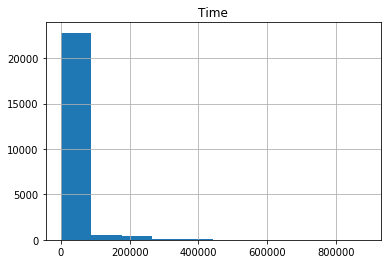

In [4]:
# Rename the survey completion column title to 'Time'
rawdata.rename(columns={'Time from Start to Finish (seconds)':'Time'}, inplace=True)

# Change data type to create histogram
rawdata['Time'] = rawdata.Time.astype(float)

# Create histogram
rawdata.hist(column='Time')


Let's remove surveys with completion time less than 4mins or longer than 600minutes

No bogus data has 18648 records and 395 features


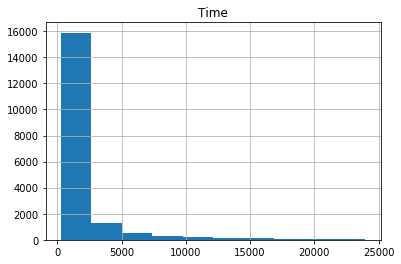

In [5]:
less4 = rawdata[round(rawdata.iloc[:,0].astype(int) / 60) <= 4].index
nobogusdata = rawdata.drop(less4, axis=0)
more600 = nobogusdata[round(nobogusdata.iloc[:,0].astype(int) / 60) >= 400].index
nobogusdata = nobogusdata.drop(more600, axis=0)

# Create histogram
nobogusdata.hist(column='Time')

shape = nobogusdata.shape
print('No bogus data has {} records and {} features'.format(shape[0], shape[1]))

For the purpose of this project, all free text filled responses were removed.


In [6]:
#First, let's remove all free text columns
MultChoiceAns = nobogusdata.drop(['Q1_OTHER_TEXT', 'Q6_OTHER_TEXT', 'Q7_OTHER_TEXT', 'Q8',
                 'Q11_OTHER_TEXT','Q12_Part_1_TEXT', 'Q12_Part_2_TEXT', 'Q12_Part_3_TEXT', 'Q12_Part_4_TEXT',
                 'Q12_Part_5_TEXT', 'Q12_OTHER_TEXT', 'Q13_OTHER_TEXT', 'Q14_OTHER_TEXT', 'Q15_OTHER_TEXT',
                 'Q16_OTHER_TEXT', 'Q17_OTHER_TEXT', 'Q18_OTHER_TEXT', 'Q19_OTHER_TEXT', 'Q20_OTHER_TEXT',
                 'Q21_OTHER_TEXT', 'Q22_OTHER_TEXT', 'Q27_OTHER_TEXT', 'Q28_OTHER_TEXT', 'Q29_OTHER_TEXT',
                 'Q30_OTHER_TEXT', 'Q31_OTHER_TEXT', 'Q33_OTHER_TEXT', 'Q34_OTHER_TEXT', 'Q35_OTHER_TEXT',
                 'Q36_OTHER_TEXT', 'Q37_OTHER_TEXT', 'Q38_OTHER_TEXT', 'Q42_OTHER_TEXT', 'Q49_OTHER_TEXT',
                 'Q50_OTHER_TEXT'], axis=1)

#Also remove Q8: 'Duration of current position' data is too messy.

shape = MultChoiceAns.shape
print('Multiple choice data has {} records and {} features'.format(shape[0], shape[1]))

Multiple choice data has 18648 records and 360 features


The first 6 column are based on personal data.

Q1: Gender
Q2: Age
Q3: Country
Q4: Education Level
Q5: Undergraduate Major
Q6: Job Role
Q7: Industry
Q9: Salary

Let's clean those columns and do EDA.

In [7]:
# Convert category fields to category types
for col in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q9']:
   MultChoiceAns[col] = MultChoiceAns[col].astype('category')

MultChoiceAns.info(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18648 entries, 1 to 23859
Data columns (total 360 columns):
Time                   float64
Q1                     category
Q2                     category
Q3                     category
Q4                     category
Q5                     category
Q6                     category
Q7                     category
Q9                     category
Q10                    object
Q11_Part_1             object
Q11_Part_2             object
Q11_Part_3             object
Q11_Part_4             object
Q11_Part_5             object
Q11_Part_6             object
Q11_Part_7             object
Q12_MULTIPLE_CHOICE    object
Q13_Part_1             object
Q13_Part_2             object
Q13_Part_3             object
Q13_Part_4             object
Q13_Part_5             object
Q13_Part_6             object
Q13_Part_7             object
Q13_Part_8             object
Q13_Part_9             object
Q13_Part_10            object
Q13_Part_11            object
Q13

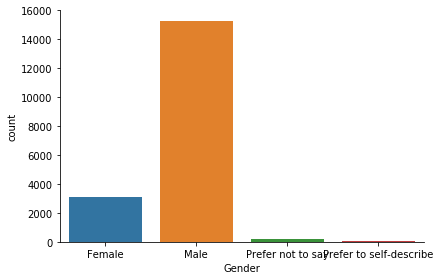

In [8]:
# Review Q1 data
fg = sns.factorplot('Q1', data=MultChoiceAns, kind='count', aspect=1.5)
fg.set_xlabels('Gender')

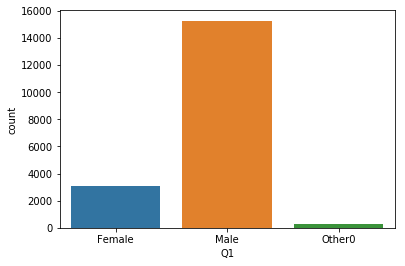

In [9]:
# Combine 'other' gender descriptions and blank to other
MultChoiceAns['Q1'] = MultChoiceAns['Q1'].replace('Prefer not to say', 'Other0')
MultChoiceAns['Q1'] = MultChoiceAns['Q1'].replace('Prefer to self-describe', 'Other0')
MultChoiceAns['Q1'] = MultChoiceAns['Q1'].replace(' ', 'Other0')

fg = sns.countplot(x='Q1', data=MultChoiceAns)

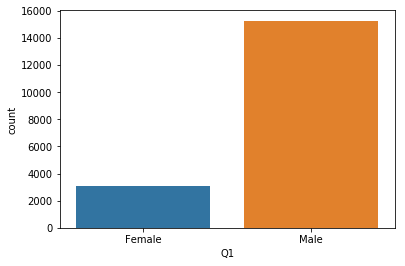

In [10]:
# Remove other

MultChoiceAns = MultChoiceAns.drop(MultChoiceAns[(MultChoiceAns.Q1 == 'Other0')].index, axis=0)
fg = sns.countplot(x='Q1', data=MultChoiceAns)

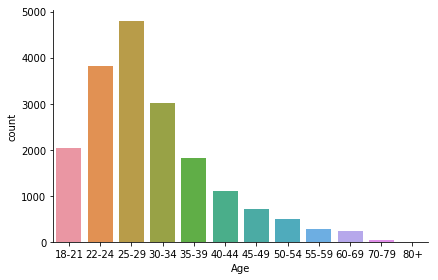

In [11]:
# Review Q2 data
fg = sns.factorplot('Q2', data=MultChoiceAns, kind='count', aspect=1.5)
fg.set_xlabels('Age')

In [12]:
# Combine the last three categories
MultChoiceAns['Q2'] = MultChoiceAns['Q2'].replace('60-69', '60+')
MultChoiceAns['Q2'] = MultChoiceAns['Q2'].replace('70-79', '60+')
MultChoiceAns['Q2'] = MultChoiceAns['Q2'].replace('80+', '60+')
#MultChoiceAns.apply(pd.Series.replace, to_replace=1, value=2)

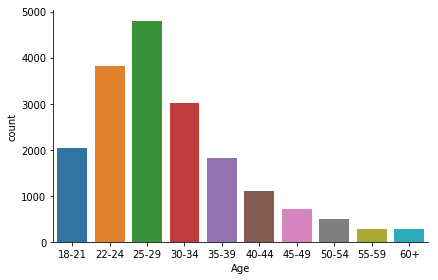

In [13]:
fg = sns.factorplot('Q2', data=MultChoiceAns, kind='count', order=['18-21', '22-24', '25-29', '30-34', '35-39', '40-44',
                                                                   '45-49', '50-54', '55-59', '60+'], aspect=1.5)
fg.set_xlabels('Age')

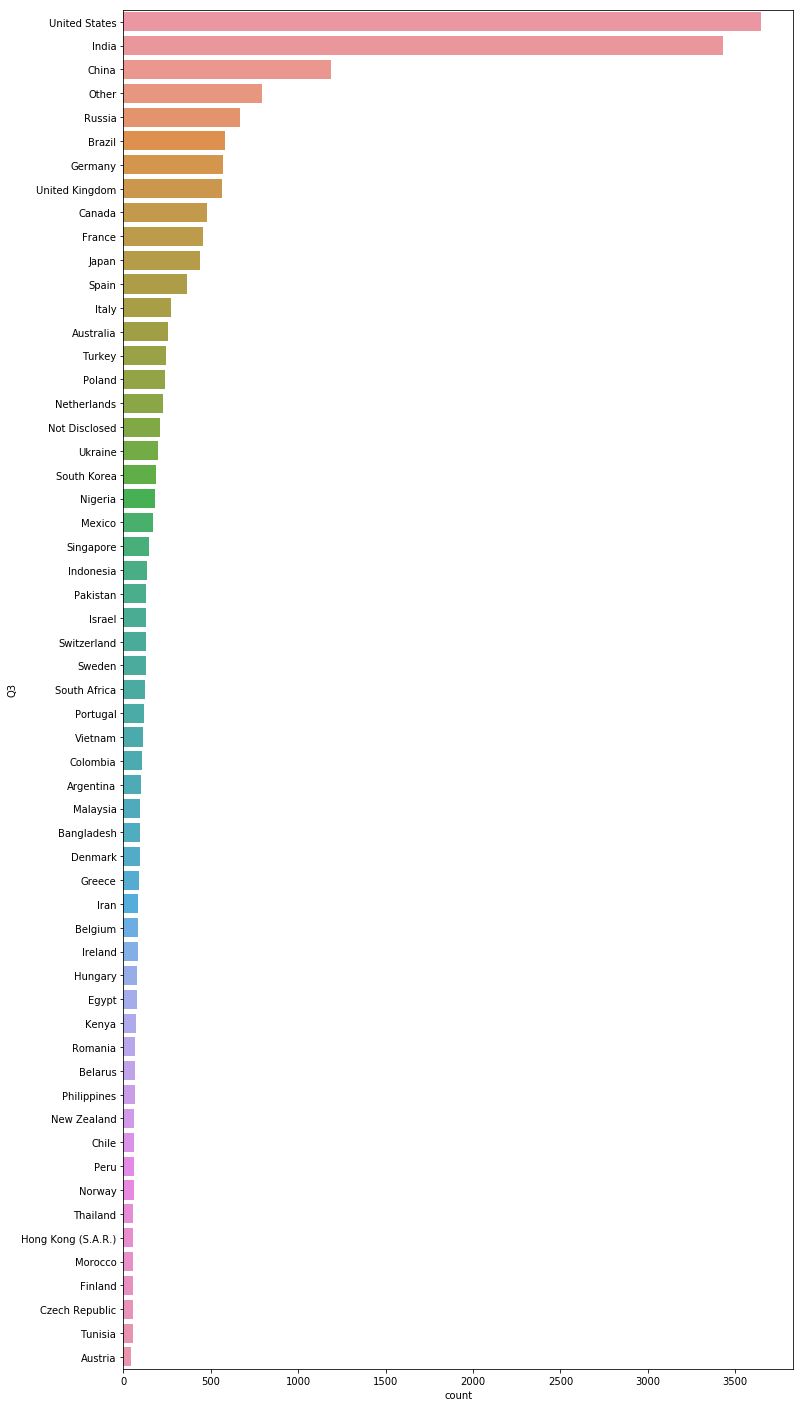

In [14]:
# Q3 No missing data in country but cleaned some long country names
MultChoiceAns['Q3'] = MultChoiceAns['Q3'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
MultChoiceAns['Q3'] = MultChoiceAns['Q3'].replace('United States of America', 'United States')
MultChoiceAns['Q3'] = MultChoiceAns['Q3'].replace('I do not wish to disclose my location', 'Not Disclosed')
MultChoiceAns['Q3'] = MultChoiceAns['Q3'].replace('Iran, Islamic Republic of...', 'Iran')
MultChoiceAns['Q3'] = MultChoiceAns['Q3'].replace('Hong Kong \(S.A.R.\)', 'Hong Kong')
MultChoiceAns['Q3'] = MultChoiceAns['Q3'].replace('Viet Nam', 'Vietnam')
MultChoiceAns['Q3'] = MultChoiceAns['Q3'].replace('Republic of Korea', 'South Korea')

a = MultChoiceAns.groupby('Q3')['Q3'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q3']


# Establish size of chart first
f, ax = plt.subplots(figsize=(12, 25))
fg = sns.countplot(y='Q3', data=MultChoiceAns, order = L, orient="v")

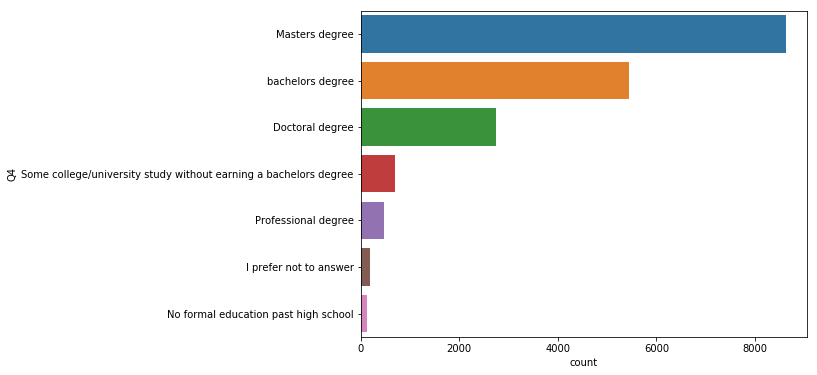

In [15]:
# Review Q4 Educational Level
a = MultChoiceAns.groupby('Q4')['Q4'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q4']

f, ax = plt.subplots(figsize=(8, 6))
fg = sns.countplot(y='Q4', data=MultChoiceAns, order = L, orient="v")

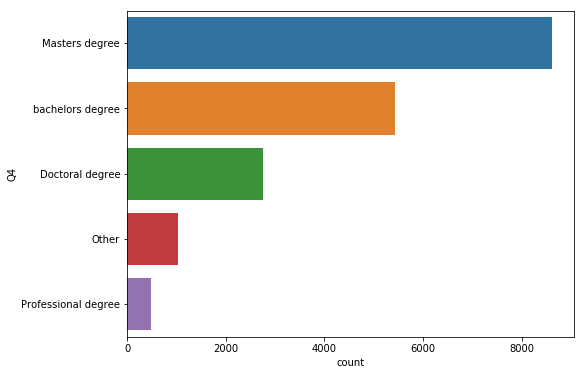

In [16]:
# Combine 'I prefer not to answer', 'No formal education past high school', and 
#'Some college/university study without earning a bachelor's degree' with 'Other'

MultChoiceAns['Q4'] = MultChoiceAns['Q4'].replace('I prefer not to answer', 'Other')
MultChoiceAns['Q4'] = MultChoiceAns['Q4'].replace('No formal education past high school', 'Other')
MultChoiceAns['Q4'] = MultChoiceAns['Q4'].replace('Some college/university study without earning a bachelors degree', 'Other')

a = MultChoiceAns.groupby('Q4')['Q4'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L= a['Q4']

f, ax = plt.subplots(figsize=(8, 6))
fg = sns.countplot(y='Q4', data=MultChoiceAns, order=L, orient="v")

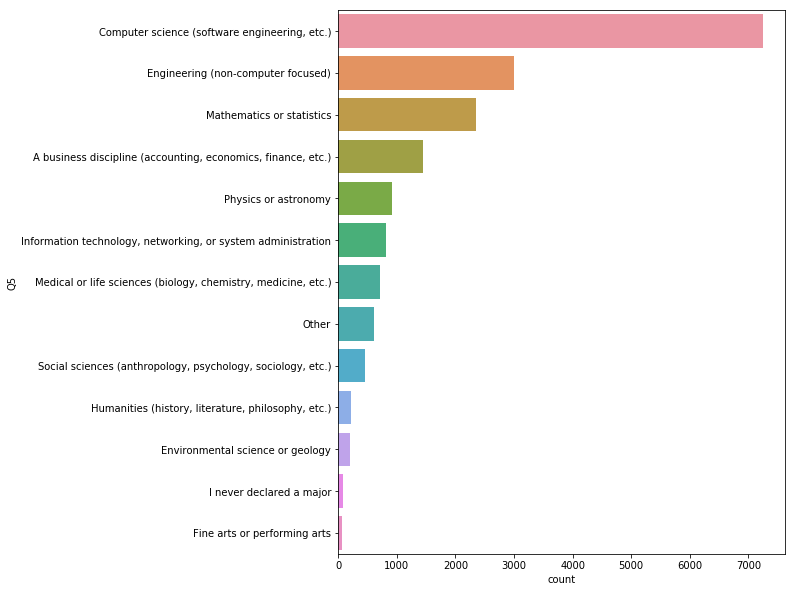

In [17]:
# Review Q5 Bachelor Field
a = MultChoiceAns.groupby('Q5')['Q5'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q5']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q5', data=MultChoiceAns, order=L, orient="v")

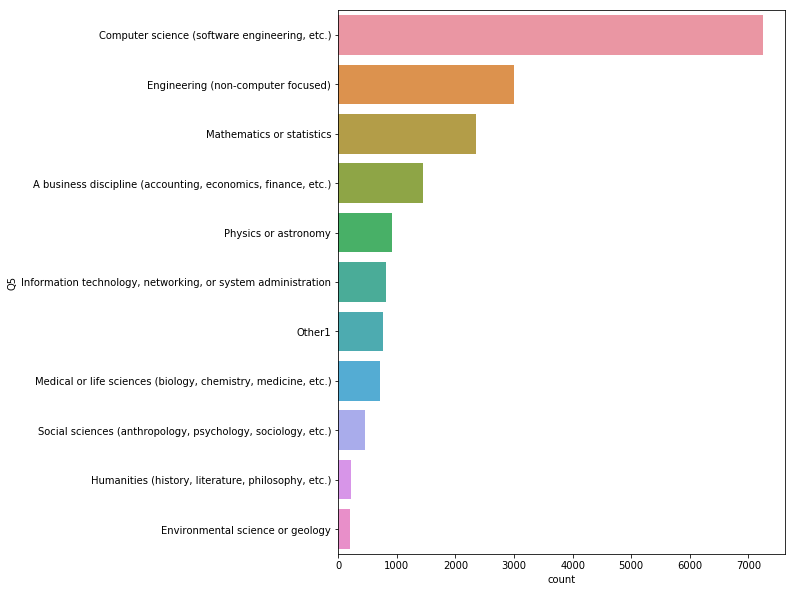

In [18]:
# Combine 'Fine arts or performing arts' and  'I never declare a major' with other
MultChoiceAns['Q5'] = MultChoiceAns['Q5'].replace('Fine arts or performing arts', 'Other1')
MultChoiceAns['Q5'] = MultChoiceAns['Q5'].replace('I never declared a major', 'Other1')
MultChoiceAns['Q5'] = MultChoiceAns['Q5'].replace('Other', 'Other1')

a = MultChoiceAns.groupby('Q5')['Q5'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q5']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q5', data=MultChoiceAns, order=L, orient="v")


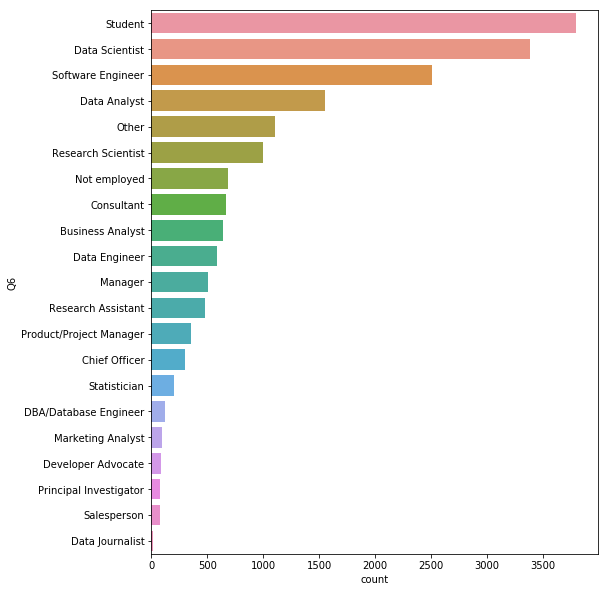

In [19]:
# Review Q6 Job Role

a = MultChoiceAns.groupby('Q6')['Q6'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q6']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q6', data=MultChoiceAns, order=L, orient="v")

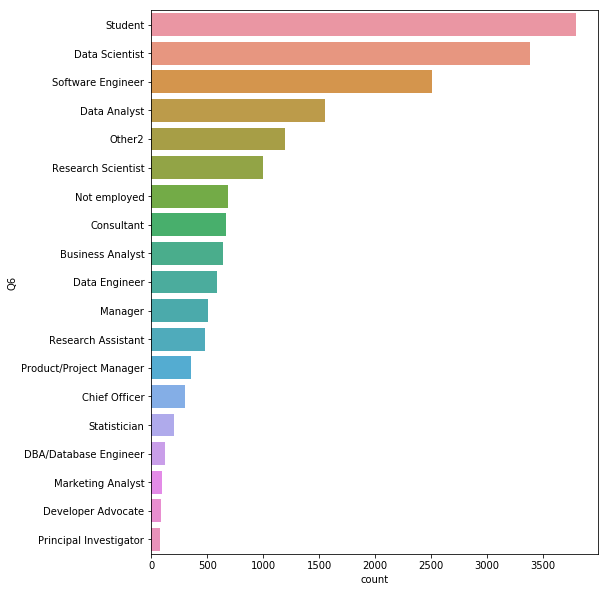

In [20]:
# Combine 'Salesperson' and 'Data Journalist' as Other
MultChoiceAns['Q6'] = MultChoiceAns['Q6'].replace('Data Journalist', 'Other2')
MultChoiceAns['Q6'] = MultChoiceAns['Q6'].replace('Salesperson', 'Other2')
MultChoiceAns['Q6'] = MultChoiceAns['Q6'].replace('Other', 'Other2')

a = MultChoiceAns.groupby('Q6')['Q6'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q6']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q6', data=MultChoiceAns, order=L, orient="v")

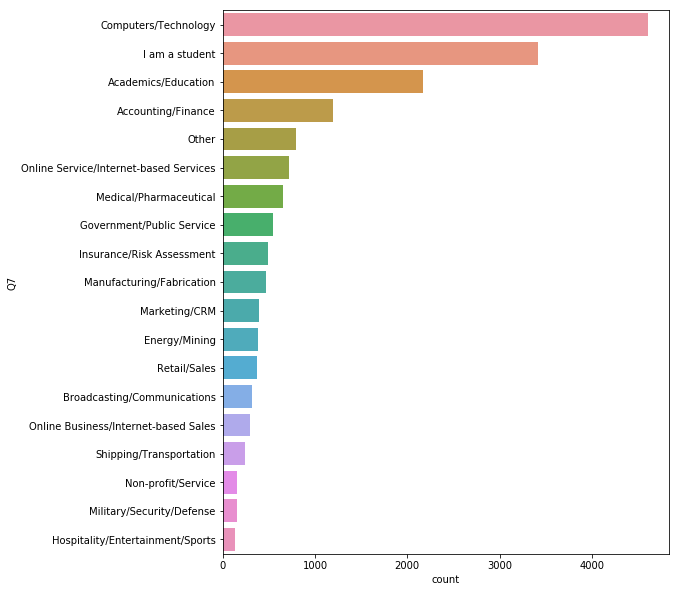

In [21]:
# Review Q7 Industry
a = MultChoiceAns.groupby('Q7')['Q7'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q7']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q7', data=MultChoiceAns, order=L, orient="v")

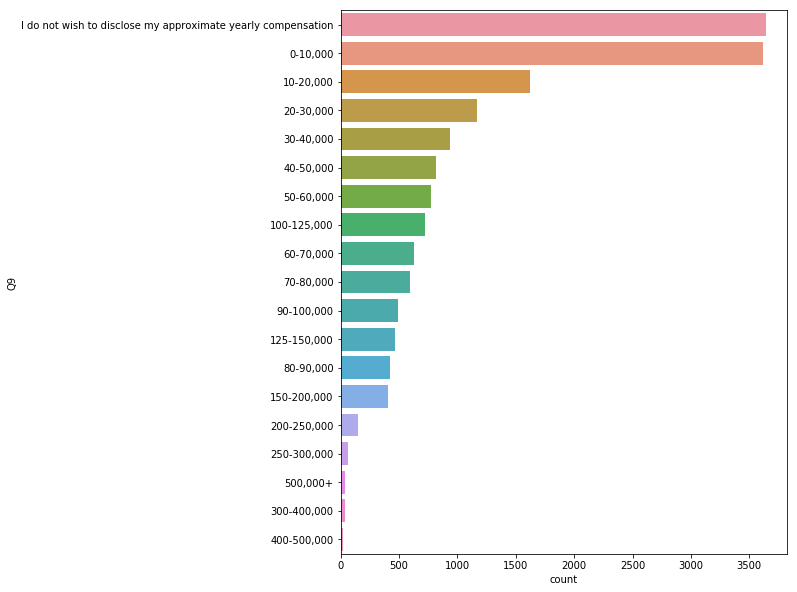

In [22]:
# Review Q9 Salary
a = MultChoiceAns.groupby('Q9')['Q9'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q9']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q9', data=MultChoiceAns, order=L, orient="v")

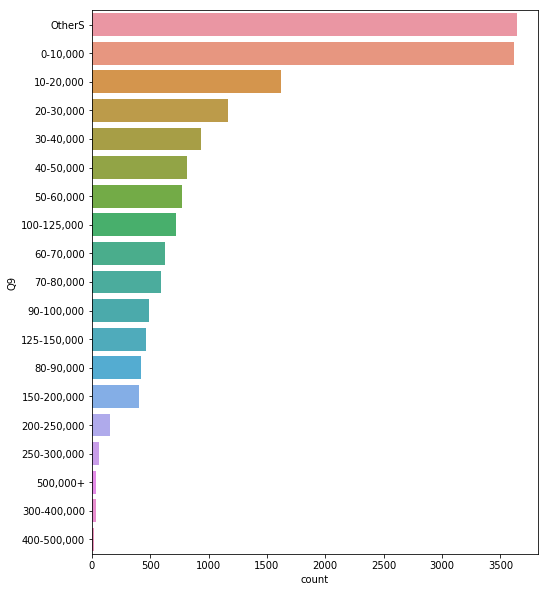

In [23]:
MultChoiceAns['Q9'] = MultChoiceAns['Q9'].replace('I do not wish to disclose my approximate yearly compensation', 'OtherS')
a = MultChoiceAns.groupby('Q9')['Q9'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q9']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q9', data=MultChoiceAns, order=L, orient="v")

#Remove surveys chose I do not wish to disclose my approximate yearly compensation
MultChoiceAns = MultChoiceAns.drop(MultChoiceAns[MultChoiceAns.Q9=='OtherS'].index, axis=0)

#Remove surveys with blank salary fields
MultChoiceAns = MultChoiceAns.drop(MultChoiceAns[MultChoiceAns.Q9.isna()].index, axis=0)

#Combine salary ranges over $200,000
MultChoiceAns['Q9'] = MultChoiceAns['Q9'].replace('200-250,000', '200,000+')
MultChoiceAns['Q9'] = MultChoiceAns['Q9'].replace('250-300,000', '200,000+')
MultChoiceAns['Q9'] = MultChoiceAns['Q9'].replace('300-400,000', '200,000+')
MultChoiceAns['Q9'] = MultChoiceAns['Q9'].replace('400-500,000', '200,000+')
MultChoiceAns['Q9'] = MultChoiceAns['Q9'].replace('500,000+', '200,000+')

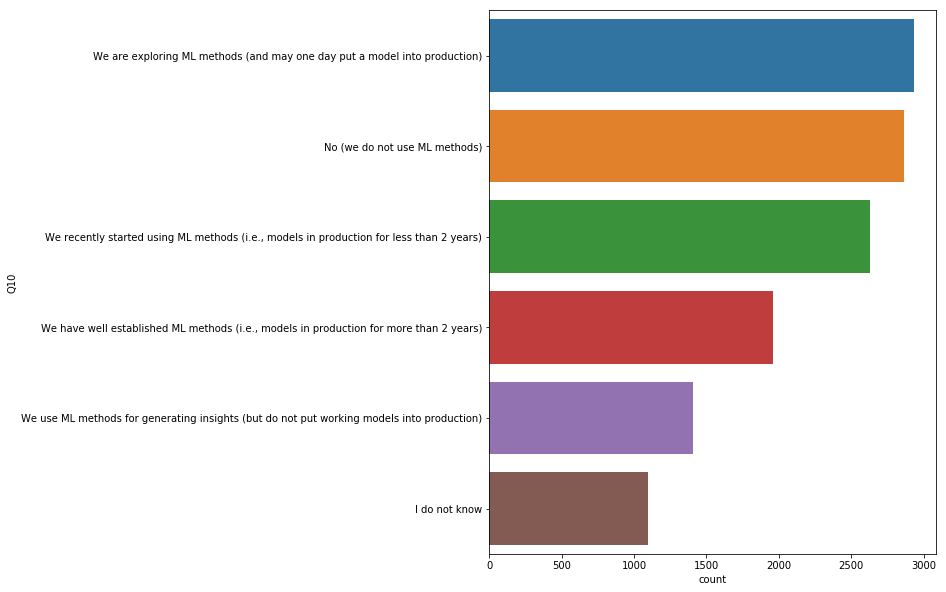

In [24]:
# Review Q10 Industry
a = MultChoiceAns.groupby('Q10')['Q10'].count().reset_index(name='count').sort_values(['count'], ascending=False)
L = a['Q10']

f, ax = plt.subplots(figsize=(8, 10))
fg = sns.countplot(y='Q10', data=MultChoiceAns, order=L, orient="v")

In [25]:
MultChoiceAns.Q9.isna().sum()

0

In [26]:
shape = MultChoiceAns.shape
print('Multiple choice data now has {} records and {} features'.format(shape[0], shape[1]))

Multiple choice data now has 12968 records and 360 features


Let's convert salary into a number instead of a range (it is calculated in thousand dollars).

In [27]:
compensation = MultChoiceAns.Q9.str.replace(',', '').str.replace('200000\+', '200-200000').str.split('-')
MultChoiceAns['SalaryNumerical'] = compensation.apply(lambda x: (int(x[0]) * 1000 + int(x[1]))/ 2) / 1000 # it is calculated in thousand dollars
print('Dataset Shape: ', MultChoiceAns.shape)
MultChoiceAns.head(3)

Dataset Shape:  (12968, 361)


,Time,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q9,Q10,...,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,SalaryNumerical
2,434.0,Male,30-34,Indonesia,bachelors degree,Engineering (non-computer focused),Other2,Manufacturing/Fabrication,"10-20,000",No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
3,718.0,Female,30-34,United States,Masters degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,"0-10,000",I do not know,...,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,5.0
5,731.0,Male,22-24,India,Masters degree,Mathematics or statistics,Data Analyst,I am a student,"0-10,000",I do not know,...,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,5.0


In [28]:
#MultChoiceAns.to_csv("C:\\Users\\brisa.ponce\\UT_analytics\\C5\\C5T4\\MultChoiceAns.csv", sep=',')

<BarContainer object of 18 artists>

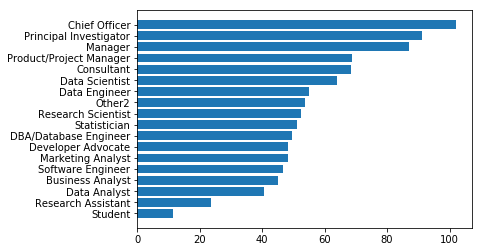

In [29]:
#This shows job roles by avarage salary
RolebySalary = MultChoiceAns.groupby("Q6",as_index=False).agg({"SalaryNumerical":"mean"})
RolebySalary  = RolebySalary.sort_values(by='SalaryNumerical', ascending=True)
plt.barh(RolebySalary['Q6'],RolebySalary['SalaryNumerical']) 

<BarContainer object of 57 artists>

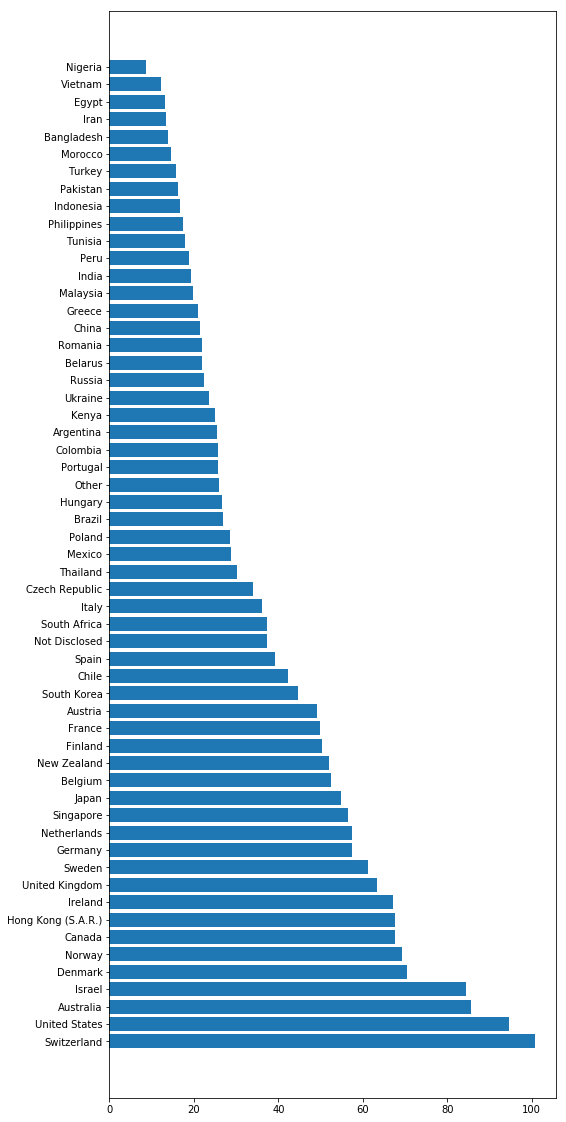

In [30]:
#This shows country by avarage salary 
f, ax = plt.subplots(figsize=(8, 20))
CountrybySalary = MultChoiceAns.groupby("Q3",as_index=False).agg({"SalaryNumerical":"mean"})
CountrybySalary  = CountrybySalary.sort_values(by='SalaryNumerical', ascending=False)
plt.barh(CountrybySalary['Q3'],CountrybySalary['SalaryNumerical']) 

From the two graphs above, we can see that Israel, Australia, United States, and Switzerland and job roles Chief Officer, Principal Investigator, and Manager drive the top 20% salary.

At this point, I move on to cleaning the other 385 survey columns. I decided to clean them in Excel as I am press for time. I remove any column that has less than 20% responses. I removed several columns that I didn't think applied to salary. 

In [31]:
# Bringing in edited data
EditedData = pd.read_csv('MultChoiceAnsEdited.csv', dtype='object')
shape = EditedData.shape
print('EditedData has {} records and {} features'.format(shape[0], shape[1]))
#EditedData.head(4)

EditedData has 12968 records and 88 features


In [32]:
# Fill empty cells with 0
EditedData.fillna("0", inplace = True) 

In [33]:
#EditedData.to_csv("C:\\Users\\brisa.ponce\\UT_analytics\\C5\\C5T4\\EditedDataRev1.csv", sep=',')

After further review of my data, I realize that there are still some columns that are either redundant or have little to do with salary so I remove them. Final data now has 65 columns.

In [34]:
EditedDataRev2 = pd.read_csv('EditedDataRev2.csv')
shape = EditedDataRev2.shape
print('EditedDataRev2 has {} records and {} features'.format(shape[0], shape[1]))
#EditedDataRev2.head(4)


EditedDataRev2 has 12968 records and 65 features


In [35]:
# Finding the compensation that separates the Top 20% most welll paid from the Bottom 80%
top20flag = EditedDataRev2.SalaryNumerical.quantile(0.8)
top20flag

85.0

Looking back at the job role vs avg salary, we can see that Student are the lowest and is bringing down our top 20%. Since the company I work for will not be hiring students, let's remove them from our analysis.

In [36]:
EditedDataRev2['not_student'] = (EditedDataRev2['Q6'] != 'Student') & (EditedDataRev2['Q7'] != 'I am a student')

EditedDataRev2 = EditedDataRev2.drop(EditedDataRev2[EditedDataRev2.not_student==False].index, axis=0)

shape = EditedDataRev2.shape
print('EditedDataRev2 has {} records and {} features'.format(shape[0], shape[1]))
#EditedDataRev2.info(3)

EditedDataRev2 has 10593 records and 66 features


In [37]:
EditedDataRev2.head(4)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q9,Q13UsedJupyterPython,Q13UsedRStudio,...,Q36UsedCoursera,Q36UsededX,Q36UsedDataCamp,Q36UsedKaggleLearn,Q36UsedUdemy,Q38LikesKaggleForums,Q38LikesMediumBlogPosts,Q48,SalaryNumerical,not_student
0,Male,30-34,Indonesia,bachelors degree,Engineering (non-computer focused),Other2,Manufacturing/Fabrication,"10-20,000",0,0,...,0,0,0,0,0,0,0,0,15.0,True
3,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other2,Academics/Education,"10-20,000",0,1,...,0,0,1,0,0,0,0,No Opinion,15.0,True
4,Male,18-21,India,Masters degree,"Information technology, networking, or system ...",Other2,Other,"0-10,000",1,0,...,0,0,0,1,1,1,1,Not Confident,5.0,True
5,Male,30-34,Hungary,Masters degree,Engineering (non-computer focused),Software Engineer,Online Service/Internet-based Services,"20-30,000",1,0,...,0,0,0,0,0,0,0,Somewhat Confident,25.0,True


In [38]:
# Finding the compensation that separates the Top 20% most welll paid from the Bottom 80% (without students)
top20flag_no_students = EditedDataRev2.SalaryNumerical.quantile(0.8)
top20flag_no_students

95.0

In [39]:
# Creating a flag for Top 20% when there are no students in the dataset
EditedDataRev2['top20_no_students'] = EditedDataRev2.SalaryNumerical > top20flag_no_students

#EditedDataRev2.info()
EditedDataRev2.head(40)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q9,Q13UsedJupyterPython,Q13UsedRStudio,...,Q36UsededX,Q36UsedDataCamp,Q36UsedKaggleLearn,Q36UsedUdemy,Q38LikesKaggleForums,Q38LikesMediumBlogPosts,Q48,SalaryNumerical,not_student,top20_no_students
0,Male,30-34,Indonesia,bachelors degree,Engineering (non-computer focused),Other2,Manufacturing/Fabrication,"10-20,000",0,0,...,0,0,0,0,0,0,0,15.0,True,False
3,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other2,Academics/Education,"10-20,000",0,1,...,0,1,0,0,0,0,No Opinion,15.0,True,False
4,Male,18-21,India,Masters degree,"Information technology, networking, or system ...",Other2,Other,"0-10,000",1,0,...,0,0,1,1,1,1,Not Confident,5.0,True,False
5,Male,30-34,Hungary,Masters degree,Engineering (non-computer focused),Software Engineer,Online Service/Internet-based Services,"20-30,000",1,0,...,0,0,0,0,0,0,Somewhat Confident,25.0,True,False
6,Male,40-44,United States,Masters degree,Engineering (non-computer focused),Data Scientist,Other,"125-150,000",0,0,...,0,0,1,0,0,0,Somewhat Confident,137.5,True,True
8,Male,25-29,United States,bachelors degree,Mathematics or statistics,Research Assistant,Academics/Education,"30-40,000",1,1,...,0,0,0,0,0,1,Not Confident,35.0,True,False
9,Female,25-29,Argentina,bachelors degree,"A business discipline (accounting, economics, ...",Data Analyst,Other,"10-20,000",1,1,...,1,1,0,1,0,0,Somewhat Confident,15.0,True,False
10,Male,25-29,Japan,Masters degree,Engineering (non-computer focused),Data Scientist,Medical/Pharmaceutical,"30-40,000",1,0,...,0,0,0,0,1,0,Not Confident At All,35.0,True,False
11,Male,40-44,Colombia,Masters degree,Environmental science or geology,Data Scientist,Energy/Mining,"50-60,000",0,1,...,0,0,0,0,1,1,Not Confident,55.0,True,False
12,Male,25-29,Nigeria,Professional degree,"Medical or life sciences (biology, chemistry, ...",Other2,Retail/Sales,"0-10,000",1,0,...,1,1,0,0,0,1,Somewhat Confident,5.0,True,False


In [40]:
#for col in ['Q1', 'Q2', 'Q3','Q4', 'Q5', 'Q6', 'Q7', 'Q26', 'Q48', 'SalaryNumerical']:
#   EditedDataRev2[col] = EditedDataRev2[col].astype('category')


#Removing a few columns in preparation to dummified the data and run the models
EditedDataRev2 = EditedDataRev2.drop(['Q9', 'SalaryNumerical','not_student'], axis=1)

#EditedDataRev2.info(3)

shape = EditedDataRev2.shape
print('EditedDataRev2 has {} records and {} features'.format(shape[0], shape[1]))

#data for iteration # 2
EditedDataRev2.to_csv("C:\\Users\\brisa.ponce\\UT_analytics\\C5\\C5T4\\EditedDataRev3.csv", sep=',')

EditedDataRev2 has 10593 records and 64 features


In [41]:
#EditedDataRev2Dummy[1:64].astype('int64')

#MultChoiceAns[col].astype('category')

In [42]:
#dummyData = pd.get_dummies(EditedDataRev2.Q1)

#EditedDataRev2Dummy = EditedDataRev2.merge(dummyData, left_index=Ture, right_index=True)
#https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40

#dummyData = pd.get_dummies(EditedDataRev2['Q1', 'Q2'])
EditedDataRev2Dummy = pd.get_dummies(data=EditedDataRev2, columns=['Q1', 'Q2', 'Q3','Q4', 'Q5', 'Q6', 'Q7', 'Q26', 'Q48'])

In [43]:
EditedDataRev2Dummy.info(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10593 entries, 0 to 12967
Data columns (total 188 columns):
Q13UsedJupyterPython                                                int64
Q13UsedRStudio                                                      int64
Q13UsedPyCharm                                                      int64
Q13UsedVisualStudioCode                                             int64
Q13UsedAtom                                                         int64
Q13UsedMATLAB                                                       int64
Q13UsedVisualStudio                                                 int64
Q13UsedNotepad                                                      int64
Q13UsedSublimeText                                                  int64
Q13UsedVim                                                          int64
Q14UsedKaggleKernels                                                int64
Q14UsedJupyterHubBinder                                             int64
Q1

In [44]:
EditedDataRev2Dummy.head(4)

,Q13UsedJupyterPython,Q13UsedRStudio,Q13UsedPyCharm,Q13UsedVisualStudioCode,Q13UsedAtom,Q13UsedMATLAB,Q13UsedVisualStudio,Q13UsedNotepad,Q13UsedSublimeText,Q13UsedVim,...,Q26_Definitely yes,Q26_Maybe,Q26_Probably not,Q26_Probably yes,Q48_0,Q48_Confident,Q48_No Opinion,Q48_Not Confident,Q48_Not Confident At All,Q48_Somewhat Confident
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,1,0,1,0,1,0,1,1,1,0,...,0,0,1,0,0,0,0,1,0,0
5,1,0,1,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1


# Modeling

# Iteration #1

In [45]:
# Split our data columns into features and target tables
X = EditedDataRev2Dummy.drop(columns=['top20_no_students'])
y = EditedDataRev2Dummy[['top20_no_students']].astype('float')

In [46]:
print(X.shape)

(10593, 187)


In [47]:
# Then split the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1984)

print("Training Rows: {} \nTest Rows: {}".format(len(X_train), len(X_test)))

Training Rows: 7415 
Test Rows: 3178


In [48]:
# list of different classifiers we are going to test
clfs = {
'LogisticRegression' : LogisticRegression(),
'GaussianNB': GaussianNB(),
'RandomForest': RandomForestClassifier(),
'DecisionTreeClassifier': DecisionTreeClassifier(),
'SVM': SVC(),
'KNeighborsClassifier': KNeighborsClassifier(),
'GradientBoosting': GradientBoostingClassifier()
}

In [49]:
# code block to test all models in clfs and generate a report
models_report = pd.DataFrame(columns = ['Model', 'Precision_score', 'Recall_score','F1_score', 'Kappa', 'Accuracy'])

for clf, clf_name in zip(clfs.values(), clfs.keys()):
    clf.fit(X_train,y_train.values.ravel())
    y_pred = clf.predict(X_test)
    y_score = clf.score(X_test,y_test)
    
    #print('Calculating {}'.format(clf_name))
    t = pd.Series({ 
                     'Model': clf_name,
                     'Precision_score': metrics.precision_score(y_test
                                                                , y_pred),
                     'Recall_score': metrics.recall_score(y_test, y_pred),
                     'F1_score': metrics.f1_score(y_test, y_pred),
                     'Kappa': metrics.cohen_kappa_score(y_test, y_pred),        
                     'Accuracy': metrics.accuracy_score(y_test, y_pred)}
                   )

    models_report = models_report.append(t, ignore_index = True)

models_report

,Model,Precision_score,Recall_score,F1_score,Kappa,Accuracy
0,LogisticRegression,0.731591,0.567219,0.639004,0.575679,0.890497
1,GaussianNB,0.211507,0.961326,0.346729,0.092555,0.381057
2,RandomForest,0.710084,0.311234,0.432778,0.366844,0.860604
3,DecisionTreeClassifier,0.480865,0.532228,0.505245,0.396989,0.821901
4,SVM,0.780255,0.451197,0.571762,0.510470,0.884519
5,KNeighborsClassifier,0.530120,0.324125,0.402286,0.313240,0.835431
6,GradientBoosting,0.727506,0.521179,0.607296,0.541967,0.884833


Accuracy of the Baseline GBM on test set: 0.885


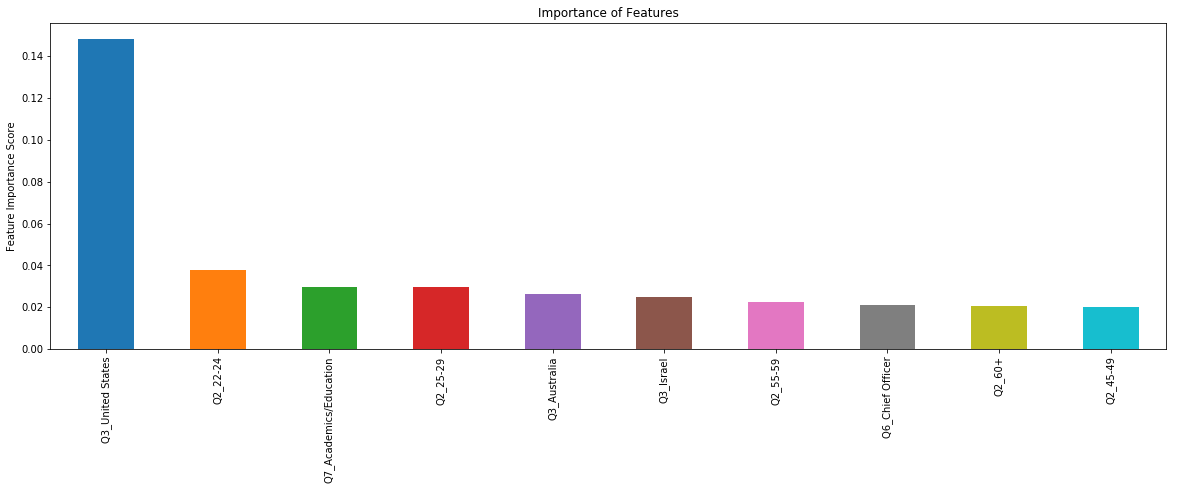

In [50]:
# Chose GradientBoostingClassifier as the main model
baseline = GradientBoostingClassifier()

baseline.fit(X_train,y_train.values.ravel())
predictors=list(X_train)
f, ax = plt.subplots(figsize=(20, 6))
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False).head(10)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the Baseline GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
#print(classification_report(y_test, pred))

From the feature importance above, we see that country and age impact salary the most. That is really not helping me much to understand what to look for when interviewing candidates for the Data Analyst or Data Scientist positions. I wonder what would happen to the results if I remove country and age information to the data and rerun the model. Let's find out.

# Iteration #2

In [51]:
EditedDataRev3 = pd.read_csv('EditedDataRev3.csv')
EditedDataRev3.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10593 entries, 0 to 10592
Data columns (total 65 columns):
Unnamed: 0                       10593 non-null int64
Q1                               10593 non-null object
Q2                               10593 non-null object
Q3                               10593 non-null object
Q4                               10593 non-null object
Q5                               10593 non-null object
Q6                               10593 non-null object
Q7                               10593 non-null object
Q13UsedJupyterPython             10593 non-null int64
Q13UsedRStudio                   10593 non-null int64
Q13UsedPyCharm                   10593 non-null int64
Q13UsedVisualStudioCode          10593 non-null int64
Q13UsedAtom                      10593 non-null int64
Q13UsedMATLAB                    10593 non-null int64
Q13UsedVisualStudio              10593 non-null int64
Q13UsedNotepad                   10593 non-null int64
Q13UsedSublimeText  

In [52]:
EditedDataRev3.head(3)

,Unnamed: 0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q13UsedJupyterPython,Q13UsedRStudio,...,Q36UsedUdacity,Q36UsedCoursera,Q36UsededX,Q36UsedDataCamp,Q36UsedKaggleLearn,Q36UsedUdemy,Q38LikesKaggleForums,Q38LikesMediumBlogPosts,Q48,top20_no_students
0,0,Male,30-34,Indonesia,bachelors degree,Engineering (non-computer focused),Other2,Manufacturing/Fabrication,0,0,...,0,0,0,0,0,0,0,0,0,False
1,3,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other2,Academics/Education,0,1,...,0,0,0,1,0,0,0,0,No Opinion,False
2,4,Male,18-21,India,Masters degree,"Information technology, networking, or system ...",Other2,Other,1,0,...,1,0,0,0,1,1,1,1,Not Confident,False


In [53]:
# EditedDataRev3 = EditedDataRev3[1:3].drop()
# Removed the first column, gender, age, and country.
EditedDataRev3.drop(EditedDataRev3.columns[[0, 1, 2, 3, 6]], axis=1, inplace=True)
EditedDataRev3.head(20)

,Q4,Q5,Q7,Q13UsedJupyterPython,Q13UsedRStudio,Q13UsedPyCharm,Q13UsedVisualStudioCode,Q13UsedAtom,Q13UsedMATLAB,Q13UsedVisualStudio,...,Q36UsedUdacity,Q36UsedCoursera,Q36UsededX,Q36UsedDataCamp,Q36UsedKaggleLearn,Q36UsedUdemy,Q38LikesKaggleForums,Q38LikesMediumBlogPosts,Q48,top20_no_students
0,bachelors degree,Engineering (non-computer focused),Manufacturing/Fabrication,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1,Doctoral degree,"Information technology, networking, or system ...",Academics/Education,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,No Opinion,False
2,Masters degree,"Information technology, networking, or system ...",Other,1,0,1,0,1,0,1,...,1,0,0,0,1,1,1,1,Not Confident,False
3,Masters degree,Engineering (non-computer focused),Online Service/Internet-based Services,1,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,Somewhat Confident,False
4,Masters degree,Engineering (non-computer focused),Other,0,0,0,0,0,1,1,...,1,1,0,0,1,0,0,0,Somewhat Confident,True
5,bachelors degree,Mathematics or statistics,Academics/Education,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,1,Not Confident,False
6,bachelors degree,"A business discipline (accounting, economics, ...",Other,1,1,0,0,0,0,0,...,0,1,1,1,0,1,0,0,Somewhat Confident,False
7,Masters degree,Engineering (non-computer focused),Medical/Pharmaceutical,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,Not Confident At All,False
8,Masters degree,Environmental science or geology,Energy/Mining,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,Not Confident,False
9,Professional degree,"Medical or life sciences (biology, chemistry, ...",Retail/Sales,1,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,Somewhat Confident,False


In [54]:
EditedDataRev3Dummy = pd.get_dummies(data=EditedDataRev3, columns=['Q4', 'Q5', 'Q7', 'Q26', 'Q48'])

In [55]:
# Split our data columns into features and target tables
X = EditedDataRev3Dummy.drop(columns=['top20_no_students'])
y = EditedDataRev3Dummy[['top20_no_students']].astype('float')

# Then split the rows into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1984)

# list of different classifiers we are going to test
clfs = {
'LogisticRegression' : LogisticRegression(),
'GaussianNB': GaussianNB(),
'RandomForest': RandomForestClassifier(),
'DecisionTreeClassifier': DecisionTreeClassifier(),
'SVM': SVC(),
'KNeighborsClassifier': KNeighborsClassifier(),
'GradientBoosting': GradientBoostingClassifier()
}

# code block to test all models in clfs and generate a report
models_report = pd.DataFrame(columns = ['Model', 'Precision_score', 'Recall_score','F1_score', 'Kappa', 'Accuracy'])

for clf, clf_name in zip(clfs.values(), clfs.keys()):
    clf.fit(X_train,y_train.values.ravel())
    y_pred = clf.predict(X_test)
    y_score = clf.score(X_test,y_test)
    
    #print('Calculating {}'.format(clf_name))
    t = pd.Series({ 
                     'Model': clf_name,
                     'Precision_score': metrics.precision_score(y_test
                                                                , y_pred),
                     'Recall_score': metrics.recall_score(y_test, y_pred),
                     'F1_score': metrics.f1_score(y_test, y_pred),
                     'Kappa': metrics.cohen_kappa_score(y_test, y_pred),        
                     'Accuracy': metrics.accuracy_score(y_test, y_pred)}
                   )

    models_report = models_report.append(t, ignore_index = True)

models_report

C:\Users\brisa.ponce\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\brisa.ponce\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



,Model,Precision_score,Recall_score,F1_score,Kappa,Accuracy
0,LogisticRegression,0.523438,0.123389,0.199702,0.143895,0.831026
1,GaussianNB,0.253236,0.576427,0.351883,0.150099,0.637193
2,RandomForest,0.461538,0.066298,0.115942,0.076295,0.827250
3,DecisionTreeClassifier,0.262739,0.303867,0.281810,0.120658,0.735368
4,SVM,0.000000,0.000000,0.000000,0.000000,0.829138
5,KNeighborsClassifier,0.347639,0.149171,0.208763,0.118295,0.806797
6,GradientBoosting,0.566038,0.110497,0.184900,0.136717,0.833543


Text(0,0.5,'Feature Importance Score')

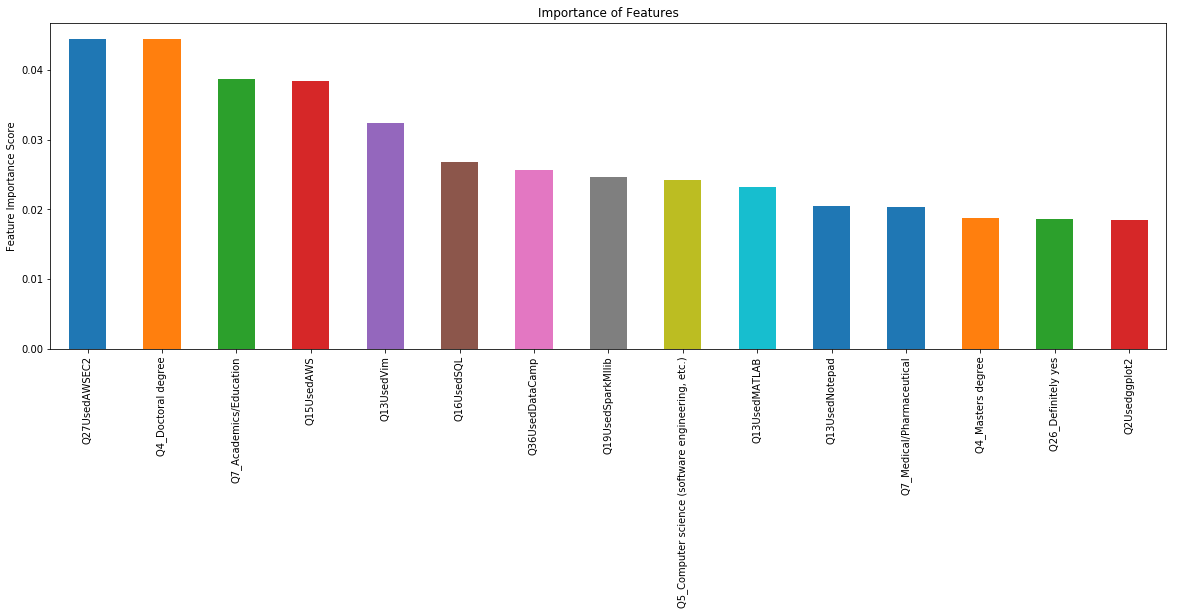

In [56]:
# Chose GradientBoostingClassifier as the main model
baseline = GradientBoostingClassifier()

baseline.fit(X_train,y_train.values.ravel())
predictors=list(X_train)
f, ax = plt.subplots(figsize=(20, 6))
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False).head(15)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
#print('Accuracy of the Baseline GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
#pred=baseline.predict(X_test)
#print(classification_report(y_test, pred))

In [57]:
EditedDataRev3['top20_no_students'].value_counts()

False    8720
True     1873
Name: top20_no_students, dtype: int64

An important factor to note in this model, is that Top 20% are only 17% of the data. This is a case of imbalance data. 

The best metric to look at is F1 Score. "The F1 score is the harmonic mean of precision and recall taking both metrics into account. In iteration #2, accuracy for GradientBoosting model is .83 but the F1 Score is .18. According to these results, this model is not performing well.

To improve the model, next steps could be to balance the data by undersampling the majority class. But at this point, the quantity of data reduces significantly. Perhaps, this data set is not a good data set to understand what drives the salary for Data Analysts or Data Scientist.